### Install dependencies

In [1]:
!pip install boto3 sagemaker langchain langchain-community langchain-core faiss-cpu requests opensearch-py sentence-transformers langchain-text-splitters requests-aws4auth qdrant-client -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 10.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 37.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Load CSV data from S3

In [2]:
!pwd

/home/ec2-user/SageMaker/Enterprise-RAG/notebooks


In [3]:
import boto3
import pandas as pd

s3 = boto3.client('s3')
bucket_name = 'recipes-rag'

In [4]:
file_key = 'recipes_w_cleaning_time_combined_features.parquet'
s3.download_file(bucket_name, file_key, f'../data/{file_key}')
df = pd.read_parquet(f'../data/{file_key}')

df.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,CookTime_Minutes,PrepTime_Minutes,TotalTime_Minutes,Combined_Features_Clean
0,38.0,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09 21:46:00+00:00,Make and share this Low-Fat Berry Blue Frozen ...,[https://img.sndimg.com/food/image/upload/w_55...,...,3.6,30.2,3.2,4.0,None,"[Toss 2 cups berries with sugar., Let stand fo...",1440,45,1485,Low-Fat Berry Blue Frozen Dessert Frozen Desse...
1,39.0,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29 13:12:00+00:00,Make and share this Biryani recipe from Food.com.,[https://img.sndimg.com/food/image/upload/w_55...,...,9.0,20.4,63.4,6.0,None,[Soak saffron in warm milk for 5 minutes and p...,25,240,265,Biryani Chicken Breast Make share Biryani reci...
2,40.0,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05 19:52:00+00:00,This is from one of my first Good House Keepi...,[https://img.sndimg.com/food/image/upload/w_55...,...,0.4,77.2,0.3,4.0,None,"[Into a 1 quart Jar with tight fitting lid, pu...",5,30,35,Best Lemonade Beverages one first Good House K...
3,41.0,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03 14:54:00+00:00,This dish is best prepared a day in advance to...,[https://img.sndimg.com/food/image/upload/w_55...,...,17.3,32.1,29.3,2.0,4 kebabs,"[Drain the tofu, carefully squeezing out exces...",20,1440,1460,Carina's Tofu-Vegetable Kebabs Soy/Tofu dish b...
4,42.0,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19 06:19:00+00:00,Make and share this Cabbage Soup recipe from F...,[https://img.sndimg.com/food/image/upload/w_55...,...,4.8,17.7,4.3,4.0,None,"[Mix everything together and bring to a boil.,...",30,20,50,Cabbage Soup Vegetable Make share Cabbage Soup...


In [5]:
df.columns

Index(['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime',
       'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory',
       'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions',
       'CookTime_Minutes', 'PrepTime_Minutes', 'TotalTime_Minutes',
       'Combined_Features_Clean'],
      dtype='object')

In [6]:
str(df.iloc[0]['Combined_Features_Clean'])

'Low-Fat Berry Blue Frozen Dessert Frozen Desserts Make share Low-Fat Berry Blue Frozen Dessert recipe Food.com. Dessert Low Protein Low Cholesterol Healthy Free Of... Summer Weeknight Freezer Easy'

In [9]:
df = df[df['AggregatedRating'].notna()]
df.shape

(269294, 32)

### Load data into chunked documents

In [7]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

In [8]:
embedding_model = HuggingFaceEmbeddings(model_name="multi-qa-mpnet-base-dot-v1")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Note: chunking may not be useful for us as the EDA has the following about description length
print(new_recipe['Combined_Features_Clean'].str.len().describe())


count    522517.000000\
mean        211.461774\
std         122.388646\
min          44.000000\
25%         131.000000\
50%         180.000000\
75%         255.000000\
max        4174.000000\
Name: Combined_Features_Clean, dtype: float64

In [10]:
def create_textsplitter(chunks, overlaps):
    splits = {}
    for chunk in chunks:
        for overlap in overlaps:
            splits[f'chunk{str(chunk)}_overlap{str(overlap)}'] = RecursiveCharacterTextSplitter(chunk_size=chunk, chunk_overlap=overlap)
    return splits

In [11]:
chunks = [128, 256, 512, 1024, 2048]
overlaps = [.25, .2, .15, .1]

text_splits = create_textsplitter(chunks, overlaps)

In [12]:
text_splits['chunk1024_overlap0.25']

In [13]:
def create_documents(df):
    documents = []
    for index, row in df.iterrows():
        metadata = {
            'recipe_id': str(row['RecipeId']) if not pd.isna(row['RecipeId']) else 'No ID Available',
            'name': str(row['Name']) if not pd.isna(row['Name']) else 'No Name Available',
            'cook_time': str(row['CookTime']) if not pd.isna(row['CookTime']) else 'No Cook Time Available',
            'prep_time': str(row['PrepTime']) if not pd.isna(row['PrepTime']) else 'No Prep Time Available',
            'total_time': str(row['TotalTime']) if not pd.isna(row['TotalTime']) else 'No Total Time Available',
            'recipe_category': str(row['RecipeCategory']) if not pd.isna(row['RecipeCategory']) else 'No Category Available',
            'keywords': str(row['Keywords']) if not pd.isna(row['Keywords']).all() else 'No Keywords Available',
            'aggregated_rating': str(row['AggregatedRating']) if not pd.isna(row['AggregatedRating']) else 'No Rating Available',
            'review_count': str(row['ReviewCount']) if not pd.isna(row['ReviewCount']) else 'No Reviews Available',
            'calories': str(row['Calories']) if not pd.isna(row['Calories']) else 'No Calories Information Available',
            'fat_content': str(row['FatContent']) if not pd.isna(row['FatContent']) else 'No Fat Content Available',
            'saturated_fat_content': str(row['SaturatedFatContent']) if not pd.isna(row['SaturatedFatContent']) else 'No Saturated Fat Content Available',
            'cholesterol_content': str(row['CholesterolContent']) if not pd.isna(row['CholesterolContent']) else 'No Cholesterol Content Available',
            'sodium_content': str(row['SodiumContent']) if not pd.isna(row['SodiumContent']) else 'No Sodium Content Available',
            'carbohydrate_content': str(row['CarbohydrateContent']) if not pd.isna(row['CarbohydrateContent']) else 'No Carbohydrate Content Available',
            'sugar_content': str(row['SugarContent']) if not pd.isna(row['SugarContent']) else 'No Sugar Content Available',
            'protein_content': str(row['ProteinContent']) if not pd.isna(row['ProteinContent']) else 'No Protein Content Available',
            'recipe_servings': str(row['RecipeServings']) if not pd.isna(row['RecipeServings']) else 'No Servings Information Available',
            'recipe_yield': str(row['RecipeYield']) if not pd.isna(row['RecipeYield']) else 'No Yield Information Available'
        }

        # Use Combined_Features_Clean for the document content
        text = str(row['Combined_Features_Clean'])
        doc = Document(page_content=text, metadata=metadata)
        documents.append(doc)
        
    return documents


In [14]:
# Take a sample of 100K receipes 
documents = create_documents(df.sample(n=100000))

In [15]:
documents[0]

Document(metadata={'recipe_id': '137828.0', 'name': 'Coney Island Chili Sauce for Hot Dogs', 'cook_time': 'PT15M', 'prep_time': 'PT10M', 'total_time': 'PT25M', 'recipe_category': 'Sauces', 'keywords': "['< 30 Mins' 'Stove Top' 'Easy']", 'aggregated_rating': '5.0', 'review_count': '14.0', 'calories': '141.7', 'fat_content': '8.7', 'saturated_fat_content': '3.4', 'cholesterol_content': '38.6', 'sodium_content': '343.4', 'carbohydrate_content': '4.4', 'sugar_content': '2.9', 'protein_content': '11.5', 'recipe_servings': '4.0', 'recipe_yield': 'No Yield Information Available'}, page_content='Coney Island Chili Sauce Hot Dogs Sauces Make share Coney Island Chili Sauce Hot Dogs recipe Food.com. < 30 Mins Stove Top Easy')

In [16]:
len(documents)

100000

In [17]:
def split_documents_with_metadata(documents, text_splitter):
    split_docs = []
    for doc in documents:
        chunks = text_splitter.split_text(doc.page_content)
        for i, chunk in enumerate(chunks):
            split_docs.append(Document(page_content=chunk, metadata={**doc.metadata, "chunk_id": i}))
    return split_docs

In [18]:
split_documents = {key: split_documents_with_metadata(documents, text_splitter_recursive) for key, text_splitter_recursive in text_splits.items()}

In [19]:
split_documents['chunk256_overlap0.25'][0]

Document(metadata={'recipe_id': '137828.0', 'name': 'Coney Island Chili Sauce for Hot Dogs', 'cook_time': 'PT15M', 'prep_time': 'PT10M', 'total_time': 'PT25M', 'recipe_category': 'Sauces', 'keywords': "['< 30 Mins' 'Stove Top' 'Easy']", 'aggregated_rating': '5.0', 'review_count': '14.0', 'calories': '141.7', 'fat_content': '8.7', 'saturated_fat_content': '3.4', 'cholesterol_content': '38.6', 'sodium_content': '343.4', 'carbohydrate_content': '4.4', 'sugar_content': '2.9', 'protein_content': '11.5', 'recipe_servings': '4.0', 'recipe_yield': 'No Yield Information Available', 'chunk_id': 0}, page_content='Coney Island Chili Sauce Hot Dogs Sauces Make share Coney Island Chili Sauce Hot Dogs recipe Food.com. < 30 Mins Stove Top Easy')

In [20]:
# We have > 500,000 recipes, this takes a long time to run
from langchain_community.vectorstores import Qdrant

# From documents with no chunking
# qdrant_store = Qdrant.from_documents(documents,
#     embedding_model,
#     location=":memory:",
# )

# from split documents (specify the chunk and overlap key)
qdrant_store = Qdrant.from_documents(split_documents['chunk1024_overlap0.25'],
    embedding_model,
    location=":memory:",
)

In [21]:
qdrant_retriever = qdrant_store.as_retriever()

### Reranker retriever

In [22]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [23]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

qdrant_retriever_rerank = qdrant_store.as_retriever(search_type='mmr', search_kwargs={"k": 50, 'lambda_mult': 0.5})
reranker_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
compressor = CrossEncoderReranker(model=reranker_model, top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=qdrant_retriever_rerank
)

compressed_docs = compression_retriever.invoke("What pizza can I make in 20 minutes?")
pretty_print_docs(compressed_docs)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Document 1:

French Bread Pizza (A Step Up) < 30 Mins recipe quick weeknight meal nice combination melding flavors. Thanks Cook's Country. Easy
----------------------------------------------------------------------------------------------------
Document 2:

Rice Pizza < 15 Mins Make share Rice Pizza recipe Food.com. Oven
----------------------------------------------------------------------------------------------------
Document 3:

Mini Pizzas < 30 Mins I'm pizza addict. since I'm eating healthy now, can't glorious frozen pepperoni pizzas. Making pizza much better you. delight, fantastic tasting too! Beginner Cook Easy


### Agent function definitions

In [24]:
def format_docs(docs):
    formatted_docs = []
    for doc in docs:
        formatted_docs.append(f"Metadata: {doc.metadata}\n")
    content = "\n\n".join(formatted_docs)
    
    return content

In [25]:
recipe_db_query_tool = {
  "name": "query_food_recipe_vector_db",
  "description": """
      Queries the vector database containing food recipes to retrieve the most relevant documents. 
      This function allows the model to generate and execute multiple queries as necessary to gather comprehensive context, 
      such as ingredients, preparation steps, and metadata like cuisine and diet type, ensuring accurate and thorough responses to user queries.
      """,
  "input_schema": {
    "type": "object",
    "properties": {
      "queries": {
        "type": "array",
        "items": {
          "type": "string",
          "description": "A query generated by the model to run against the vector database to fetch recipe documents."
        },
        "description": "A list of queries generated by the model to run against the vector database to fetch recipe documents."
      }
    },
    "required": ["queries"]
  }
}


### Init bedrock model, define util to stateless messaging, no fn calling

In [26]:
import json

In [27]:
bedrock_client = boto3.client('bedrock-runtime', region_name="us-east-1")

In [28]:
# We will need to tune these prompts
# query_bedrock_llm() definition NEEDS TO BE RERUN
# each time when changes are made to this prompt

baseline_sys_prompt = """
You are a helpful assistant and expert in cooking recipes.

Before answering, always make at least one call to query_food_recipe_vector_db
to retrieve the relevant context of recipes and ingredients to generate an informed
and high-quality response to the user prompt but NEVER exceed a MAXIMUM of 
3 calls to the query_food_recipe_vector_db function.

Provide a response to the user prompt about food with recommended recipes and instructions.
"""

In [29]:
# We will need to tune these prompts

baseline_sys_prompt_basic = """
You are a helpful assistant and expert in cooking recipes.
You will be provided a list of relevant context about relevant food recipes
which includes metadata like ingredients and cooking instructions.

Provide a response to the user prompt about food with recommended recipes and instructions.
"""

In [30]:
MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

def query_bedrock_llm(messages):
    response = bedrock_client.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps({
            'anthropic_version': 'bedrock-2023-05-31', # This is required to use chat style messages object 
            'system': baseline_sys_prompt,
            'messages': messages,
            'max_tokens': 3000,
            "tools": [recipe_db_query_tool],

            # This config forces the model to always call the recipe db query tool atleast once 
            # https://docs.anthropic.com/en/docs/build-with-claude/tool-use#controlling-claudes-output
            # "tool_choice": {
            #     "type": "tool",
            #     "name": recipe_db_query_tool['name']
            # },
            
            # TODO: TUNE THESE VALUES
            'temperature': 0.1, 
            'top_p': 0.9
        })
    )
    response_body = json.loads(response.get('body').read())
    
    return response_body

In [31]:
MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

def query_bedrock_llm_basic(messages):
    response = bedrock_client.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps({
            'anthropic_version': 'bedrock-2023-05-31', # This is required to use chat style messages object 
            'system': baseline_sys_prompt_basic,
            'messages': messages,
            'max_tokens': 3000,
            
            # TODO: TUNE THESE VALUES
            'temperature': 0.1, 
            'top_p': 0.9
        })
    )
    response_body = json.loads(response.get('body').read())
    
    print(response_body['content'][0]['text'])
    
    return response_body['content'][0]['text']

### Pipe langchain together

In [32]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableMap

In [33]:
baseline_user_prompt_basic = """
### Here is a context:
{context} 

### Here is a user prompt:
{query}
"""

In [34]:
baseline_user_prompt = """
### Here is a user prompt:
{query}
"""

In [35]:
def process_prompt(query_args):
    prompt_with_query = baseline_user_prompt.replace("{query}", query_args['query'])
    
    # This format doesn't matter much now, but we will use it later to 
    # persist chat history for continuous dialogue
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt_with_query
                }
            ]
        }
    ]
    
    return messages

In [36]:
def process_prompt_basic(query_args):
    prompt_with_context = baseline_user_prompt_basic.replace("{context}", query_args['context'])
    prompt_with_query = prompt_with_context.replace("{query}", query_args['query'])
    
    # This format doesn't matter much now, but we will use it later to 
    # persist chat history for continuous dialogue
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt_with_query
                }
            ]
        }
    ]
    
    return messages

In [37]:
qdrant_rag_chain = (
    RunnableMap(
        # {"context": qdrant_retriever | format_docs,
         {"query": RunnablePassthrough()}
    )
    | process_prompt
    | query_bedrock_llm
    # | parse_event_stream
)

In [38]:
qdrant_rag_chain_basic = (
    RunnableMap(
        {"context": qdrant_retriever | format_docs,
         "query": RunnablePassthrough()}
    )
    | process_prompt_basic
    | query_bedrock_llm_basic
)

In [39]:
qdrant_rag_chain_rerank = (
    RunnableMap(
        {"context": compression_retriever | format_docs,
         "query": RunnablePassthrough()}
    )
    | process_prompt_basic
    | query_bedrock_llm_basic
)

### Model generates dynamic context queries to vector db

In [40]:
test_queries = {
    '1': """
    I enjoy asian fusion food and I am a vegetarian. 
    Give me one recipe with ingredients and instructions
    """,

    '2': """
    I have a peanut allergy but I like thai food. 
    I also don't enjoy spicy food much, and want a meal with low carbs. 
    Give a recipe with ingredients and instructions
    """,

    '3': """
    Suggest a low-carb breakfast recipe that includes eggs and spinach, 
    can be prepared in under 20 minutes, 
    and is suitable for a keto diet.
    """,

    '4': """
    Suggest a healthy dinner recipe for two people that includes fish, 
    is under 500 calories per serving, 
    and can be made in less than 40 minutes.
    """,

    '5': """
    I am on a ketogenic diet and need a dinner recipe that is dairy-free, 
    low in sodium, and takes less than an hour to cook.
    """,

    '6': """
    I'm looking for a pescatarian main course that is low in saturated fat, 
    uses Asian flavors, and can be prepared in under 45 minutes.
    """,

    '7': """
    I need a diabetic-friendly, vegan breakfast recipe that is gluten-free, 
    nut-free, and low in cholesterol, but also rich in omega-3 fatty acids 
    and can be prepared the night before.
    """,

    '8': """
    I am following a strict paleo diet and need a lunch recipe that is dairy-free, 
    gluten-free, low in carbs, and low in sodium. Additionally, it should be rich in antioxidants, 
    and can be made in under 30 minutes with minimal cooking equipment.
    """
}



In [41]:
qdrant_rag_chain.invoke(test_queries['1'])

{'id': 'msg_bdrk_01Xkb4Hthn6ZHHMaKwWmn3Rw',
 'type': 'message',
 'role': 'assistant',
 'model': 'claude-3-sonnet-20240229',
 'content': [{'type': 'text',
   'text': 'Okay, let me query the food recipe vector database to find a relevant Asian fusion vegetarian recipe.'},
  {'type': 'tool_use',
   'id': 'toolu_bdrk_01CqWNVAWiA65jS9ijtmg3y9',
   'name': 'query_food_recipe_vector_db',
   'input': {'queries': ['asian fusion vegetarian recipes']}}],
 'stop_reason': 'tool_use',
 'stop_sequence': None,
 'usage': {'input_tokens': 478, 'output_tokens': 87}}

### Implement continuous dialogue and function calling

In [42]:
def generate_message(prompt):
    if type(prompt) != str:
        raise ValueError(f'Tried to call message generate_message with non-string input: {prompt}')
        
    return {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": prompt
            }
        ]
    }

In [43]:
def generate_tool_message(fn_results):
    
    return {
        "role": "user",
        "content": fn_results
    }

In [44]:
import json

# Adds the current prompt as a new message to the chat history
# and calls bedrock with the entire chat history
# Returns the response body, llm's message, and new chat history

'''
Example response body structure:
{
   "id":"msg_bdrk_01C5GGkafK7aL3P5i3rsMr1p",
   "type":"message",
   "role":"assistant",
   "model":"claude-3-sonnet-20240229",
   "content":[
      {
         "type":"tool_use",
         "id":"toolu_bdrk_01CQiYa8BMJfpJC68DuRdwQn",
         "name":"query_food_recipe_vector_db",
         "input":{
            "queries":[
               "healthy fish dinner recipe under 500 calories",
               "fish dinner recipe for two under 40 minutes"
            ]
         }
      }
   ],
   "stop_reason":"tool_use",
   "stop_sequence":"None",
   "usage":{
      "input_tokens":559,
      "output_tokens":55
   }
}
'''
def message_handler(existing_chat_history, prompt, is_tool_message=False):
    # Fn results is an array of tool response objects
    # message structure needs to reflect that
    if is_tool_message:
        user_message = generate_tool_message(prompt)
    else:
        user_message = generate_message(prompt)
    existing_chat_history.append(user_message)

    # Parse the response content
    response_body = query_bedrock_llm(existing_chat_history)
    llm_message = {
        'role': response_body['role'],
        'content': response_body['content']
    }

    # Add the response message to the chat history
    existing_chat_history.append(llm_message)
    
    return [response_body, llm_message, existing_chat_history]

In [45]:
# Executes a list of queries and returns a list of document results
def handle_vector_db_queries(queries, retriever=qdrant_retriever): 
    context_docs = []
    for query in queries:
        query_results = retriever.invoke(query)
        context_docs.extend(query_results)

    return context_docs

In [46]:
# Takes as an argument to LLM message content, returns a list of the fn result objects
def handle_function_calls(tool_call_message_content, retriever=qdrant_retriever):
    tool_results = []
    
    for tool_call in tool_call_message_content:
        # Only process messages from the LLM that are function calls
        if tool_call['type'] != 'tool_use':
            continue
        fn_id = tool_call['id']
        fn_name = tool_call['name']
        fn_args = tool_call['input']
        fn_result = {
            "type": "tool_result",
            "tool_use_id": fn_id,
        }   

        if fn_name == 'query_food_recipe_vector_db':
            if 'queries' not in fn_args:
                print(f"ERROR: Tried to call {fn_name} with invalid args {fn_args}, skipping..")
                fn_result['content'] = ""
                fn_result['is_error'] = True
                tool_results.append(fn_result)
                continue
                
            print(f"Model called {fn_name} with args {fn_args}")
            context_docs = handle_vector_db_queries(fn_args['queries'], retriever)
            context_str = format_docs(context_docs)
            fn_result['content'] = context_str
            tool_results.append(fn_result)
            
        # TODO: handle web search invocation here
        else:
            print(f"ERROR: Attempted call to unknown function {fn_name}")
            fn_result['content'] = ""
            fn_result['is_error'] = True
            tool_results.append(fn_result)

    return tool_results

### Run dynamic query function calling with test queries

In [47]:
'''
Example payload structure of response_body:

{'id': 'msg_bdrk_01REesjegNiLteurBoxW7pSt',
 'type': 'message',
 'role': 'assistant',
 'model': 'claude-3-sonnet-20240229',
 'content': [{'type': 'tool_use',
   'id': 'toolu_bdrk_01191W2FuAFTRoDqKKeJSmmn',
   'name': 'query_food_recipe_vector_db',
   'input': {'queries': ['thai food',
     'peanut free',
     'low carb',
     'not spicy']}}],
 'stop_reason': 'tool_use',
 'stop_sequence': None,
 'usage': {'input_tokens': 573, 'output_tokens': 52}}


Example payload structure of llm_message['content']:

[{'type': 'tool_use',
   'id': 'toolu_bdrk_01191W2FuAFTRoDqKKeJSmmn',
   'name': 'query_food_recipe_vector_db',
   'input': {'queries': ['thai food',
     'peanut free',
     'low carb',
     'not spicy']}}]
'''

# This function is the entry point to invoke the LLM with support for function calling
# parsing output, calling requested functions, sending output is handled here
def run_chat_loop(prompt, retriever=qdrant_retriever):
    print(f"[User]: {prompt}")
    response_body, llm_message, chat_history = message_handler(existing_chat_history=[], prompt=prompt)
    
    
    # The model wants to call tools, call them, provide response, repeat until content is generated
    while response_body['stop_reason'] == 'tool_use':
        fn_results = handle_function_calls(tool_call_message_content=llm_message['content'], retriever=retriever)

        # Send function results back to LLM as a new message with the existing chat history
        response_body, llm_message, chat_history = message_handler(
            existing_chat_history=chat_history, 
            prompt=fn_results,
            is_tool_message=True
        )

    # The model is done calling tools
    print(f"\n[Model]: {llm_message['content'][0]['text']}")
    return f"\n[Model]: {llm_message['content'][0]['text']}"


In [48]:
run_chat_loop(test_queries['1'])

[User]: 
    I enjoy asian fusion food and I am a vegetarian. 
    Give me one recipe with ingredients and instructions
    
Model called query_food_recipe_vector_db with args {'queries': ['asian fusion vegetarian recipes']}
Model called query_food_recipe_vector_db with args {'queries': ['vegetarian asian fusion recipes']}
Model called query_food_recipe_vector_db with args {'queries': ['vegetarian recipes combining multiple asian cuisines']}

[Model]: <search_quality_reflection>
The search for "vegetarian recipes combining multiple asian cuisines" provided some promising options that seem to blend flavors and ingredients from different Asian culinary traditions into fusion dishes. The sesame vinaigrette, Thai curry, and Thai-noodle peanut pasta all incorporate elements from multiple Asian cuisines in a vegetarian-friendly way. I believe I now have enough context to provide a relevant recipe recommendation.
</search_quality_reflection>

<search_quality_score>5</search_quality_score>

<r

'\n[Model]: <search_quality_reflection>\nThe search for "vegetarian recipes combining multiple asian cuisines" provided some promising options that seem to blend flavors and ingredients from different Asian culinary traditions into fusion dishes. The sesame vinaigrette, Thai curry, and Thai-noodle peanut pasta all incorporate elements from multiple Asian cuisines in a vegetarian-friendly way. I believe I now have enough context to provide a relevant recipe recommendation.\n</search_quality_reflection>\n\n<search_quality_score>5</search_quality_score>\n\n<result>\nHere is a delicious vegetarian Asian fusion recipe that combines flavors from Thai and Chinese cuisines:\n\nThai-Noodle Peanut Pasta\n\nIngredients:\n- 8 oz rice noodles or linguine \n- 1 cup shredded carrots\n- 1 cup shredded red cabbage\n- 1 cup snow peas, trimmed\n- 1/2 cup chopped green onions\n- 1/4 cup chopped cilantro\n- 1/4 cup chopped peanuts\n\nFor the Peanut Sauce:\n- 1/2 cup creamy peanut butter\n- 1/4 cup soy sauc

### Evaluation method
1. Use LLM as a judge 
2. Basic Sniff test

### Evaluation pipeline
1. Look at EDA result and determine the type of cuisine preesnt in the data. Come up with 8 "Test Questions". - Done. 
    test_query_1 to test_query_8
2. Feed the test questions in to the basic RAG, function calling RAG
3. Gather response and use the following two methods to evaluate them.
   1. LLM as a judge (provide grading ruberic) and ask the eval LLM to provide a score of 1-5.
   2. Sniff test 
  

### Recipe Grading Criteria - Pass into the Eval LLM as part of the prompt

Grading Scale (1-5)

5 - Exceptional Recipe:

    1. Accuracy: The recipe is highly accurate and closely matches the user's query, including all specified ingredients, dietary restrictions, and desired cuisine type.
    2. Clarity: The instructions are clear, easy to follow, and logically sequenced. Cooking times and temperatures are precise.
    3. Creativity: The recipe demonstrates creativity, offering a unique or interesting twist on a classic dish or a novel combination of ingredients.
    4. Completeness: The recipe includes all necessary details, such as ingredient measurements, preparation steps, serving suggestions, and any relevant tips or variations.
    5. Healthiness: The recipe provides a balanced nutritional profile, aligning with any specified health goals or dietary considerations.
    6. User Feedback: The recipe is likely to receive high ratings from users for both taste and ease of preparation.


4 - Very Good Recipe:

    1. Accuracy: The recipe mostly matches the user's query with minor deviations or substitutions that still align with the user's dietary restrictions and preferences.
    2. Clarity: The instructions are clear and easy to follow, with only minor areas that could benefit from additional detail.
    3. Creativity: The recipe shows some creativity and presents an appealing dish, though it may not be as unique as a 5-rated recipe.
    4. Completeness: The recipe includes most necessary details, but might miss a few minor tips or variations.
    5. Healthiness: The recipe is generally healthy, though it may not be as nutritionally balanced as a 5-rated recipe.
    6. User Feedback: The recipe is likely to receive good ratings from users, being tasty and reasonably easy to prepare.

3 - Good Recipe:

    1. Accuracy: The recipe has a reasonable match with the user's query but may include some inaccuracies or ingredient substitutions that slightly alter the dish's nature.
    2. Clarity: The instructions are generally clear but may have a few confusing steps or lack detailed guidance in some areas.
    3. Creativity: The recipe is standard with minimal creativity or uniqueness.
    4. Completeness: The recipe includes the essential details but lacks additional helpful information or suggestions.
    5. Healthiness: The recipe is moderately healthy but may lack balance in terms of nutritional profile.
    6. User Feedback: The recipe is expected to receive average ratings, being satisfactory but not outstanding in taste or ease of preparation.

2 - Fair Recipe:

    1. Accuracy: The recipe has noticeable discrepancies from the user's query, potentially including ingredients that were supposed to be excluded due to dietary restrictions.
    2. Clarity: The instructions are unclear or difficult to follow, with significant gaps or ambiguities.
    3. Creativity: The recipe lacks creativity and may appear bland or uninspired.
    4. Completeness: The recipe is missing several important details, such as precise measurements or key preparation steps.
    5. Healthiness: The recipe is not particularly healthy and may have an unbalanced nutritional profile.
    6. User Feedback: The recipe is likely to receive below-average ratings due to issues with taste, clarity, or preparation difficulty.

1 - Poor Recipe:

    1. Accuracy: The recipe significantly deviates from the user's query, ignoring key dietary restrictions or preferences.
    2. Clarity: The instructions are confusing, incomplete, or incorrect, making the recipe difficult or impossible to follow.
    3. Creativity: The recipe is not creative and may seem haphazard or poorly thought out.
    4. Completeness: The recipe is missing critical details, such as major ingredients, steps, or cooking times.
    5. Healthiness: The recipe is unhealthy and lacks a balanced nutritional profile.
    6. User Feedback: The recipe is likely to receive low ratings due to poor taste, difficulty in preparation, or failure to meet user expectations.

In [49]:
# Eval framework
MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0"

def query_bedrock_eval_llm(messages):
    response = bedrock_client.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps({
            'anthropic_version': 'bedrock-2023-05-31', # This is required to use chat style messages object 
            'messages': messages,
            'max_tokens': 3000,

            # This config forces the model to always call the recipe db query tool atleast once 
            # https://docs.anthropic.com/en/docs/build-with-claude/tool-use#controlling-claudes-output
            # "tool_choice": {
            #     "type": "tool",
            #     "name": recipe_db_query_tool['name']
            # },
            
            # TODO: TUNE THESE VALUES
            'temperature': 0.1, 
            'top_p': 0.9,
            'top_k' : 2,
        })
    )
    response_body = json.loads(response.get('body').read())
    
    return response_body

In [50]:
qdrant_rag_chain_eval = (
    RunnableMap(
        # {"context": qdrant_retriever | format_docs,
         {"query": RunnablePassthrough()}
    )
    | process_prompt
    | query_bedrock_eval_llm
    # | parse_event_stream
)

In [51]:
import copy
def llm_judge_eval(queries_index_list, model_responses_dict):
    
    eval_responses = copy.deepcopy(model_responses_dict)
    
    for model_name, response_dict in model_responses_dict.items():
        for i in queries_index_list:
            query = test_queries[i]
            gen_response = response_dict[i]

            eval_message = f"""
            You are a helpful assistant and expert in reviewing cooking recipes.

            Please look at the given user query, recipe generated by another LLM and follow the rubric below. Provide a score between 1-5 on how good the recipe is.

            user query : "{query}"

            Recipe generated by another LLM: "{gen_response}"

            Recipe review rubric: 

            Grading Scale (1-5)

            5 - Exceptional Recipe:

            1. Accuracy: The recipe is highly accurate and closely matches the user's query, including all specified ingredients, dietary restrictions, and desired cuisine type.
            2. Clarity: The instructions are clear, easy to follow, and logically sequenced. Cooking times and temperatures are precise.
            3. Creativity: The recipe demonstrates creativity, offering a unique or interesting twist on a classic dish or a novel combination of ingredients.
            4. Completeness: The recipe includes all necessary details, such as ingredient measurements, preparation steps, serving suggestions, and any relevant tips or variations.
            5. Healthiness: The recipe provides a balanced nutritional profile, aligning with any specified health goals or dietary considerations.
            6. User Feedback: The recipe is likely to receive high ratings from users for both taste and ease of preparation.
            4 - Very Good Recipe:

            1. Accuracy: The recipe mostly matches the user's query with minor deviations or substitutions that still align with the user's dietary restrictions and preferences.
            2. Clarity: The instructions are clear and easy to follow, with only minor areas that could benefit from additional detail.
            3. Creativity: The recipe shows some creativity and presents an appealing dish, though it may not be as unique as a 5-rated recipe.
            4. Completeness: The recipe includes most necessary details, but might miss a few minor tips or variations.
            5. Healthiness: The recipe is generally healthy, though it may not be as nutritionally balanced as a 5-rated recipe.
            6. User Feedback: The recipe is likely to receive good ratings from users, being tasty and reasonably easy to prepare.
            3 - Good Recipe:

            1. Accuracy: The recipe has a reasonable match with the user's query but may include some inaccuracies or ingredient substitutions that slightly alter the dish's nature.
            2. Clarity: The instructions are generally clear but may have a few confusing steps or lack detailed guidance in some areas.
            3. Creativity: The recipe is standard with minimal creativity or uniqueness.
            4. Completeness: The recipe includes the essential details but lacks additional helpful information or suggestions.
            5. Healthiness: The recipe is moderately healthy but may lack balance in terms of nutritional profile.
            6. User Feedback: The recipe is expected to receive average ratings, being satisfactory but not outstanding in taste or ease of preparation.
            2 - Fair Recipe:

            1. Accuracy: The recipe has noticeable discrepancies from the user's query, potentially including ingredients that were supposed to be excluded due to dietary restrictions.
            2. Clarity: The instructions are unclear or difficult to follow, with significant gaps or ambiguities.
            3. Creativity: The recipe lacks creativity and may appear bland or uninspired.
            4. Completeness: The recipe is missing several important details, such as precise measurements or key preparation steps.
            5. Healthiness: The recipe is not particularly healthy and may have an unbalanced nutritional profile.
            6. User Feedback: The recipe is likely to receive below-average ratings due to issues with taste, clarity, or preparation difficulty.
            1 - Poor Recipe:

            1. Accuracy: The recipe significantly deviates from the user's query, ignoring key dietary restrictions or preferences.
            2. Clarity: The instructions are confusing, incomplete, or incorrect, making the recipe difficult or impossible to follow.
            3. Creativity: The recipe is not creative and may seem haphazard or poorly thought out.
            4. Completeness: The recipe is missing critical details, such as major ingredients, steps, or cooking times.
            5. Healthiness: The recipe is unhealthy and lacks a balanced nutritional profile.
            6. User Feedback: The recipe is likely to receive low ratings due to poor taste, difficulty in preparation, or failure to meet user expectations.

            The response format should be the following :

            User Query : 
            Recipe reviewed : 
            Score : 
            Reasoning : 
                1. Accuracy:
                2. Clarity :
                3. Creativity :
                4. Completeness : 
                5. Healthiness : 
                6. User Feedback :
            """

            # eval_resp = qdrant_rag_chain_eval.invoke(eval_message)['content'][0]['text']
            eval_resp = qdrant_rag_chain_eval.invoke(eval_message)
            eval_responses[model_name][f"eval_{i}"] = eval_resp
            print(f'Model: {model_name}')
            print(eval_resp['content'][0]['text'])
            print("========\n")
    return eval_responses
    

In [52]:
def model_testing(query_index, model_dict):
    """
    query_index: list of indices to pull from test_queries dict
    model_dict: expected input {model_name: (model_object, boolean for function calling)}
    return dict {model_name_1: {1: response_1, 2: response_2, etc}}
    """
    # instantiate dict {model name: {1:response, 2:response2, etc}}
    model_responses = {model_name: {i: '' for i in query_index} for model_name in model_dict.keys()}
    for model_name, (model, func_call) in models_to_test.items():
        for i in queries_test_index:
            query = test_queries[i]

            if func_call:
                response = run_chat_loop(query, model) 
            else: 
                response = model.invoke(query)

            model_responses[model_name][i] = response
    return model_responses

In [106]:
# Model name: (model object, using run_chat_loop function calling)
models_to_test = {
    'baseline': (qdrant_rag_chain_basic, False),
    'rerank': (qdrant_rag_chain_rerank, False),
    'func_call_rerank': (compression_retriever, True)
}

# indexes to test from test_queries dictionary
queries_test_index = ['1', '2', '3', '4', '5']

model_responses = model_testing(queries_test_index, models_to_test)

Based on the context provided, I would recommend trying the "Vegetarian Thai Curry" recipe. This dish sounds like it would be a great fit for your preferences as a vegetarian who enjoys Asian fusion cuisine.

Here are the ingredients and instructions for the Vegetarian Thai Curry recipe:

Ingredients:
- 1 tablespoon vegetable oil
- 1 onion, diced 
- 3 cloves garlic, minced
- 1 tablespoon grated fresh ginger
- 2 tablespoons red curry paste
- 1 (13.5 oz) can coconut milk
- 1 cup vegetable broth
- 1 tablespoon brown sugar
- 2 tablespoons fish sauce (or soy sauce for a vegan option)
- 1 red bell pepper, sliced
- 1 cup sliced mushrooms
- 1 cup cubed firm tofu
- 1 cup baby spinach
- Juice of 1 lime
- Chopped cilantro for garnish

Instructions:
1. Heat the vegetable oil in a large skillet or wok over medium heat. Add the onion and sauté for 2-3 minutes until translucent.
2. Add the garlic and ginger and cook for 1 minute, stirring constantly, until fragrant.
3. Stir in the red curry paste and

In [54]:
model_responses

{'baseline': {'1': 'Based on the context provided, I would recommend trying the "Vegetarian Thai Curry" recipe. This dish seems to fit your preferences for Asian-inspired vegetarian cuisine.\n\nHere are the ingredients and instructions for the Vegetarian Thai Curry recipe:\n\nIngredients:\n- 1 tablespoon vegetable oil\n- 1 onion, diced \n- 3 cloves garlic, minced\n- 1 tablespoon grated fresh ginger\n- 2 tablespoons red curry paste\n- 1 (13.5 oz) can coconut milk\n- 1 cup vegetable broth\n- 1 tablespoon brown sugar\n- 2 tablespoons fish sauce (or soy sauce for a vegan version)\n- 1 red bell pepper, sliced\n- 1 cup sliced mushrooms\n- 1 cup broccoli florets\n- 1 cup cubed firm tofu\n- Juice of 1 lime\n- Chopped cilantro for garnish\n\nInstructions:\n\n1. Heat the vegetable oil in a large skillet or wok over medium heat. Add the onion and sauté for 2-3 minutes until translucent.\n\n2. Add the garlic and ginger and cook for 1 minute, stirring constantly, until fragrant.\n\n3. Stir in the r

In [107]:
evaluated_dict = llm_judge_eval(queries_test_index, model_responses)

Model: baseline
User Query: 
I enjoy asian fusion food and I am a vegetarian. Give me one recipe with ingredients and instructions.

Recipe reviewed:
Vegetarian Thai Curry

Score: 4

Reasoning:
1. Accuracy: The recipe closely matches the user's query, providing a vegetarian Asian fusion dish as requested.
2. Clarity: The instructions are clear and easy to follow, with detailed steps and cooking times.
3. Creativity: The recipe demonstrates creativity by combining classic Thai curry flavors with a variety of vegetables and tofu, offering an interesting twist on a traditional dish.
4. Completeness: The recipe includes all necessary details, such as ingredient measurements, preparation steps, and serving suggestions.
5. Healthiness: The recipe provides a balanced nutritional profile, with a variety of vegetables, tofu, and a coconut milk-based sauce that aligns with the user's vegetarian dietary preferences.
6. User Feedback: The recipe is likely to receive high ratings from users for its

In [108]:
evaluated_dict['func_call_rerank']['eval_1']['content'][0]['text']

"User Query: \nI enjoy asian fusion food and I am a vegetarian. Give me one recipe with ingredients and instructions.\n\nRecipe reviewed:\nGreen Beans & Tofu With Crunchy Thai Peanut Sauce\n\nScore: 4\n\nReasoning:\n1. Accuracy: The recipe closely matches the user's query, providing an Asian-inspired vegetarian dish as requested.\n2. Clarity: The instructions are clear and easy to follow, with precise cooking times and temperatures.\n3. Creativity: The recipe offers an interesting twist on a classic dish by combining green beans, tofu, and a crunchy peanut sauce.\n4. Completeness: The recipe includes all necessary details, such as ingredient measurements, preparation steps, and serving suggestions.\n5. Healthiness: The recipe provides a balanced nutritional profile, with protein-rich tofu, fresh vegetables, and a relatively low-calorie sauce.\n6. User Feedback: The recipe is likely to receive high ratings from users for its delicious flavor and ease of preparation."

In [109]:
import pickle

In [110]:
with open('results_dict.pkl', 'wb') as handle:
    pickle.dump(evaluated_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
with open('results_dict.pkl', 'rb') as handle:
    results_dict = pickle.load(handle)

## High Low similarity eval

In [60]:
%pip install --upgrade --quiet  langchain-qdrant langchain-openai langchain langchain-community

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [145]:
from qdrant_client.http import models as rest
import seaborn as sns
import matplotlib.pyplot as plt

def query_similarity_rating_eval(query_outputs, k=10, plot=True, verbose=False):
    
    for i, query_output in query_outputs.items():
        
        found_docs = {}
        for rating in df['AggregatedRating'].unique():

            # Qdrant filter condition
            rating_filter = rest.Filter(
                must=[
                        rest.FieldCondition(
                            key="metadata.aggregated_rating",
                            match=rest.MatchText(text=str(rating)),
                        )
                ]
            )

            found_docs[str(rating)] = qdrant_store.similarity_search_with_score(query_output, k=k, filter=rating_filter)

        # format doc scores for plotting
        to_display = {}
        for rating, docs in found_docs.items():
            scores = []
            for doc in docs:
                # if verbose: 
                    # print(f"Rating: {doc[0].metadata['aggregated_rating']}, {doc[0].metadata['name']}: {doc[1]}")
                scores.append(doc[1])
            to_display[rating] = scores
        
            if verbose:
                print(f"Rating: {rating} - Best Score: {round(to_display[rating][0], 3)}")
        
        # box and whisker plot
        if plot:
            # reorder ratings
            myKeys = list(to_display.keys())
            myKeys.sort()
            sorted_dict = {i: to_display[i] for i in myKeys}

            sns.boxplot(sorted_dict).set(
                xlabel='Rating', 
                ylabel='Similarity Score',
                title=f'Query {i} Similarity Scores to Recipe Ratings'
            )
            plt.show()
    
    return found_docs


In [146]:
def get_generated_outputs(results_dict, model_name):
    return {key: value for key, value in results_dict[model_name].items() if "eval" not in key}


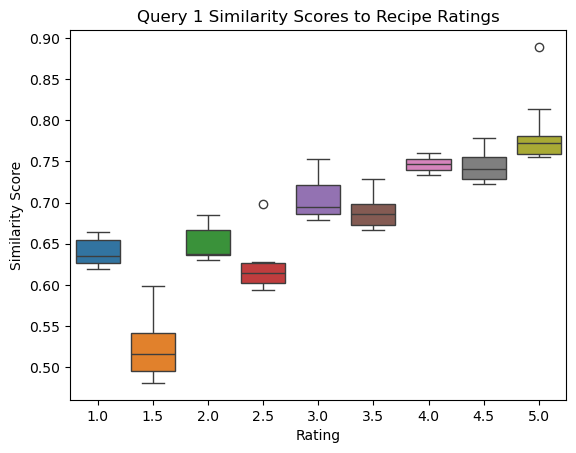

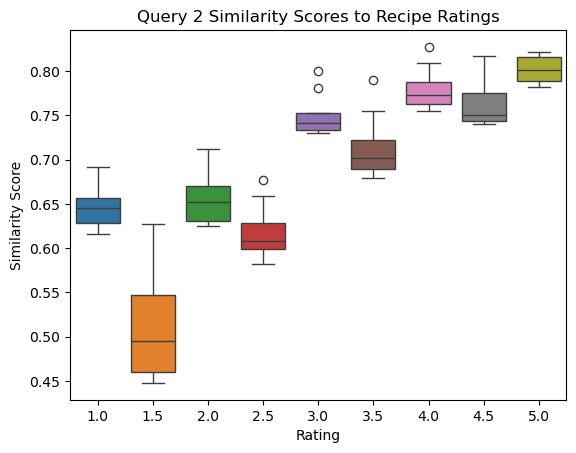

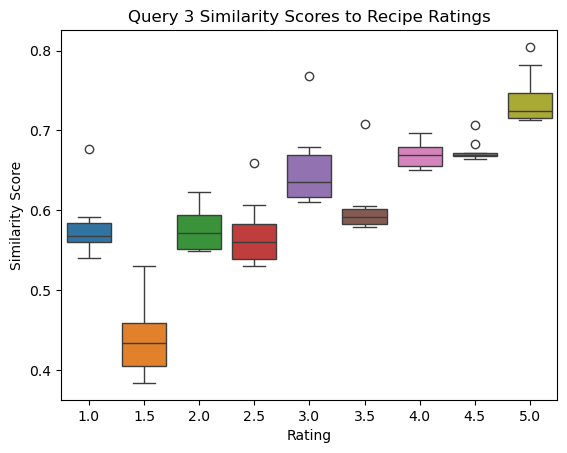

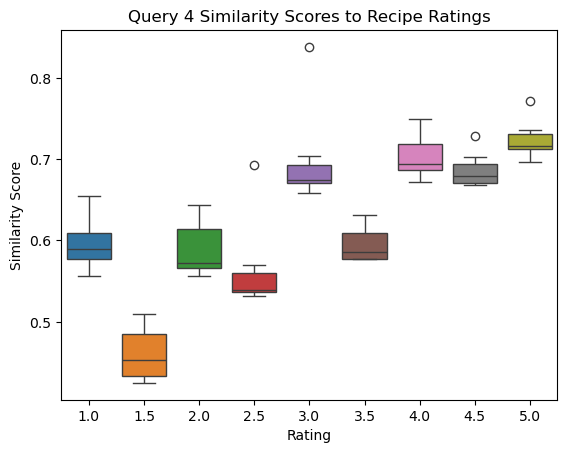

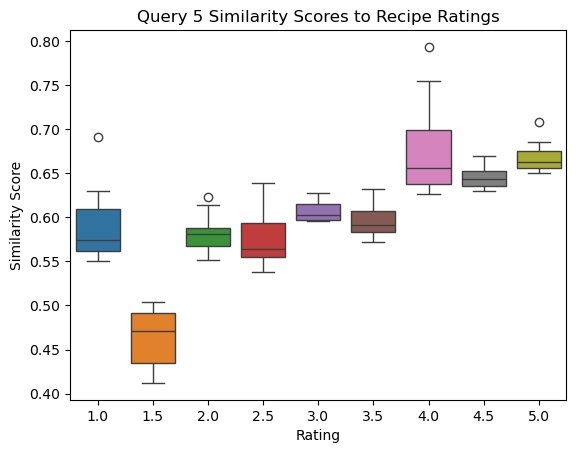

In [150]:
query_results = get_generated_outputs(results_dict, 'func_call_rerank')
found_docs = query_similarity_rating_eval(query_results, k=10)

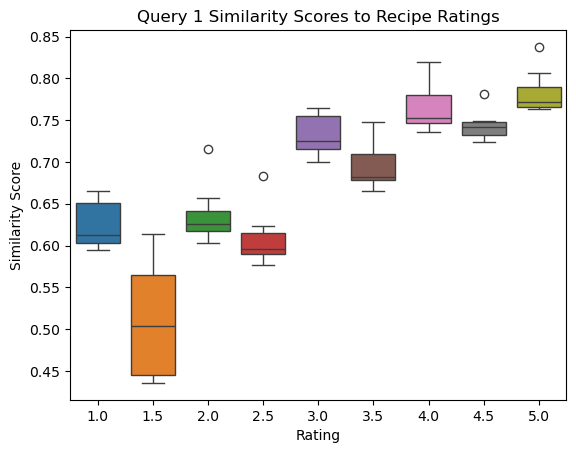

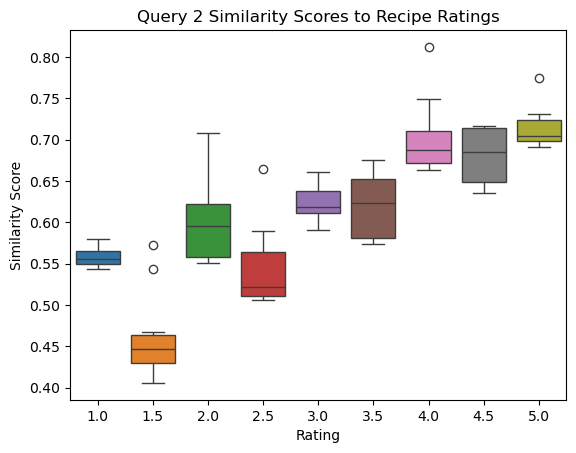

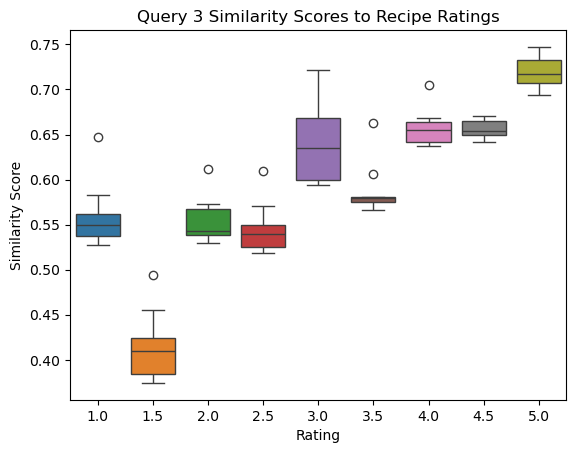

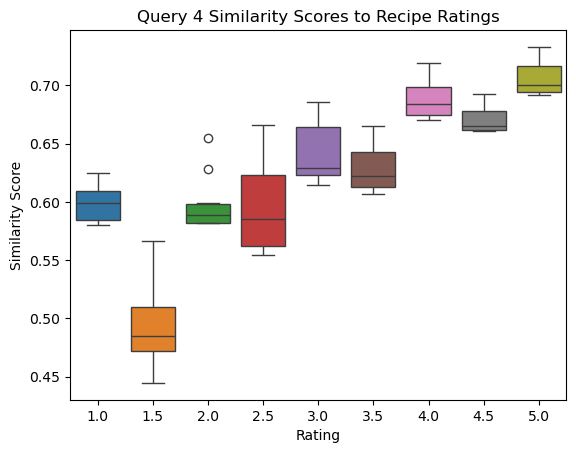

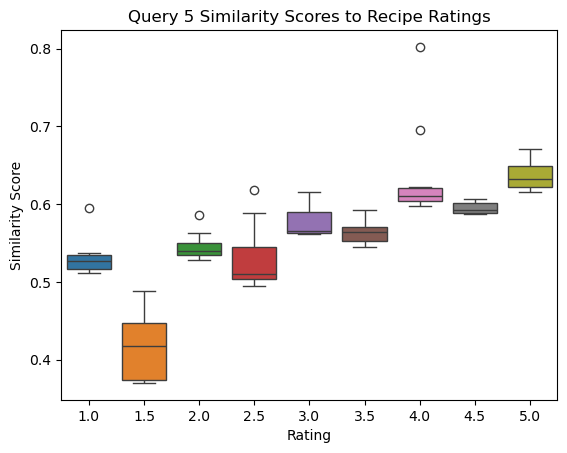

In [149]:
query_results = get_generated_outputs(results_dict, 'baseline')
found_docs = query_similarity_rating_eval(query_results, k=10)

In [90]:
query_df = pd.DataFrame.from_dict(sorted_dict)

In [92]:
query_df.max()

1.0    0.667755
1.5    0.614752
2.0    0.692700
2.5    0.698588
3.0    0.751994
3.5    0.719990
4.0    0.766309
4.5    0.778506
5.0    0.897500
dtype: float64

In [94]:
query_df.idxmax()

1.0    0
1.5    0
2.0    0
2.5    0
3.0    0
3.5    0
4.0    0
4.5    0
5.0    0
dtype: int64

In [95]:
query_df

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,0.667755,0.614752,0.692700,0.698588,0.751994,0.719990,0.766309,0.778506,0.897500
1,0.662742,0.593501,0.689006,0.636219,0.738980,0.707289,0.763624,0.770769,0.826775
2,0.661709,0.551524,0.672924,0.631822,0.734806,0.701363,0.763066,0.750990,0.784717
3,0.644531,0.532976,0.653846,0.630787,0.714480,0.701269,0.752481,0.749805,0.776402
4,0.642792,0.522842,0.650827,0.625619,0.704846,0.692341,0.743104,0.745522,0.769664
5,0.639375,0.510718,0.648202,0.612732,0.702164,0.690850,0.741707,0.743480,0.765330
6,0.636770,0.509706,0.645132,0.608526,0.689622,0.681566,0.741572,0.734069,0.761011
7,0.633361,0.506186,0.642554,0.606654,0.687382,0.679483,0.739269,0.733029,0.760280
8,0.630186,0.493285,0.641318,0.605183,0.684483,0.674373,0.738877,0.730397,0.753801
9,0.628883,0.488594,0.637891,0.601488,0.682404,0.673071,0.732938,0.728907,0.751805


## LLM as a gatekeeper

1. Allergy Check

    "I am allergic to peanuts. Can you suggest a dessert recipe for me?"
    
    "I have a shellfish allergy. Please provide a dinner recipe."
2. Dietary Restrictions

    "I follow a vegan diet. Can you give me a breakfast recipe?"
    
    "I need a gluten-free lunch recipe. What can you suggest?"
    
3. Ingredient Exclusion

    "I don't eat dairy products. Can you provide a pasta recipe?"
    
    "I avoid sugar. Please suggest a dessert recipe without sugar."
4. Multiple Restrictions

    "I am allergic to both nuts and dairy. Can you recommend a snack recipe?"
    
    "I need a gluten-free and vegan dinner recipe. What do you have?"
5. Cultural and Ethical Preferences

    "I don't eat beef for religious reasons. Can you provide a main course recipe?"
    
    "I only eat halal food. Can you give me a recipe for a special occasion?"
6. Healthy Options

    "I am on a low-carb diet. Can you suggest a low-carb dinner recipe?"
    
    "I need a low-sodium breakfast recipe. What can you recommend?"
7. Child-Friendly Recipes

    "My child is allergic to eggs. Can you suggest a kid-friendly snack recipe?"
    
    "I need a lunch recipe for my child who doesn't eat nuts or dairy."
8. Ingredient Availability

    "I don't have any tomatoes. Can you provide a salad recipe without tomatoes?"
    
    "I am out of eggs. Can you give me a baking recipe that doesn't require eggs?"
9. Medical Conditions

    "I have diabetes. Can you suggest a dessert recipe suitable for me?"
    
    "I have high cholesterol. Can you provide a heart-healthy dinner recipe?"
    
10. Explicit Avoidance

    "Please give me a recipe for chicken soup, but it must not contain any garlic."
    
    "I am looking for a recipe for a cake, but it should not include any artificial sweeteners."
    
11. Scenarios for Testing System Responses

    Direct Allergy Violation

    "I am allergic to peanuts. Can you suggest a peanut butter cookie recipe?"
12. Conflict of Dietary Preferences

    "I follow a vegan diet but also want a recipe with chicken. Can you provide one?"
    
13. Non-compliant Ingredient Substitution

    "I need a gluten-free pasta recipe, but please include wheat flour."
    
14. Multiple Contradictory Requests

    "I avoid sugar and dairy, but can you suggest a sweet and creamy dessert?"

In [66]:
gatekeeper_queries = {
    '1': """
    I am allergic to peanuts. Can you suggest a dessert recipe for me?
    """,

    '2': """
    I follow a vegan diet. Can you give me a breakfast recipe?
    """,

    '3': """
    I don't eat dairy products. Can you provide a pasta recipe?
    """,

    '4': """
    I am allergic to both nuts and dairy. Can you recommend a snack recipe?
    """,

    '5': """
    I don't eat beef for religious reasons. Can you provide a main course recipe?
    """,

    '6': """
    I need a low-sodium breakfast recipe. What can you recommend?
    """,

    '7': """
    My child is allergic to eggs. Can you suggest a kid-friendly snack recipe?
    """,

    '8': """
    I don't have any tomatoes. Can you provide a salad recipe without tomatoes?
    """
}



In [67]:
def llm_gatekeeper_eval(queries_index_list, model_responses_dict):
    
    eval_responses = copy.deepcopy(model_responses_dict)
    
    for model_name, response_dict in model_responses_dict.items():
        for i in queries_index_list:
            query = gatekeeper_queries[i]
            gen_response = response_dict[i]

            eval_message = f"""
            You are a helpful assistant and expert in reviewing and judging cooking recipes. Please be as unbiased and impartial towards the recipe.

            Please look at the given user query, recipe generated by another LLM. 
            
            Return if the response correctly follows the user's request. Answer, Yes or No.

            user query : "{query}"

            Recipe generated by another LLM: "{gen_response}"
            """

            # eval_resp = qdrant_rag_chain_eval.invoke(eval_message)['content'][0]['text']
            eval_resp = qdrant_rag_chain_eval.invoke(eval_message)
            eval_responses[model_name][f"eval_{i}"] = eval_resp
            print(f'Model: {model_name}')
            print(eval_resp['content'][0]['text'])
            print("========\n")
    return eval_responses
    

In [72]:
def model_testing(query_index, model_dict):
    """
    query_index: list of indices to pull from test_queries dict
    model_dict: expected input {model_name: (model_object, boolean for function calling)}
    return dict {model_name_1: {1: response_1, 2: response_2, etc}}
    """
    # instantiate dict {model name: {1:response, 2:response2, etc}}
    model_responses = {model_name: {i: '' for i in query_index} for model_name in model_dict.keys()}
    for model_name, (model, func_call) in models_to_test.items():
        for i in queries_test_index:
            query = gatekeeper_queries[i]

            if func_call:
                response = run_chat_loop(query, model) 
                print("====")
            else: 
                response = model.invoke(query)
                print("====")
            model_responses[model_name][i] = response
            
    return model_responses

In [73]:
# Model name: (model object, using run_chat_loop function calling)
models_to_test = {
    'baseline': (qdrant_rag_chain_basic, False),
    'rerank': (qdrant_rag_chain_rerank, False),
    'func_call_rerank': (compression_retriever, True)
}

# indexes to test from test_queries dictionary
queries_test_index = ['1', '2', '3', '4', '5', '6']

model_responses = model_testing(queries_test_index, models_to_test)

I apologize, but since you mentioned being allergic to peanuts, I would not feel comfortable recommending any of the peanut-based dessert recipes provided in the context. Peanut allergies can be very serious, and it's important to avoid those ingredients.

Instead, here are a few non-peanut dessert recipe suggestions that you may want to consider:

1. Chocolate Lava Cakes:
   - Ingredients: Chocolate, eggs, butter, sugar, flour
   - Instructions:
     1. Preheat oven to 450°F.
     2. Grease ramekins and dust with cocoa powder.
     3. Melt chocolate and butter together.
     4. Whisk in eggs, sugar, and flour until just combined.
     5. Divide batter into ramekins and bake for 8-10 minutes.
     6. Let cool for 1 minute, then invert onto plates and serve.

2. Lemon Bars:
   - Ingredients: Flour, sugar, eggs, lemon juice, butter
   - Instructions:
     1. Preheat oven to 350°F.
     2. Make the crust by mixing flour and sugar, then cutting in butter.
     3. Press the crust into a bak

In [74]:
evaluated_dict = llm_gatekeeper_eval(queries_test_index, model_responses)

Model: baseline
Yes, the response correctly follows the user's request. The LLM provided several peanut-free dessert recipe suggestions that are appropriate for someone with a peanut allergy.

Model: baseline
Yes, the response correctly follows the user's request. The recipe generated by the other LLM provides three vegan breakfast recipe options that are suitable for the user's dietary requirements.

Model: baseline
Yes, the response correctly follows the user's request for a dairy-free pasta recipe.

Model: baseline
Yes, the response correctly follows the user's request. The recipe generated by the other LLM is a nut-free and dairy-free snack option, which is suitable for the user's dietary restrictions.

Model: baseline
Yes, the response correctly follows the user's request. The recipe provided does not contain beef, which aligns with the user's dietary restriction, and it offers a main course option as requested.

Model: baseline
Yes, the response correctly follows the user's reque